In [2]:
import pickle
import collections as col
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
target_cols = [
    'toxic', 'severe_toxic', 'obscene', 'threat', 
    'insult', 'identity_hate'
]

import torch
import torch.nn
from torch.autograd import Variable
import torch.optim

In [5]:
import sys
sys.path += ["/home/zphang/nyu/ML/project/ml_project/"]

In [6]:
import imp
import src.deep
imp.reload(src.deep)

<module 'src.deep' from '/home/zphang/nyu/ML/project/ml_project/src/deep.py'>

## Data

In [68]:
with open("/home/zphang/data/ml_proj/data2/X_train_os.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("/home/zphang/data/ml_proj/data2/y_train_os.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("/home/zphang/data/ml_proj/data2/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)
with open("/home/zphang/data/ml_proj/data2/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)
with open("/home/zphang/data/ml_proj/data2/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("/home/zphang/data/ml_proj/data2/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

In [73]:
y_train = y_train[y_val.columns].fillna(0)

## Code

In [80]:
LOG_STEP = 1000
BATCH_SIZE = 256

param_dict = {
    "top_k_words": 50000,
    "hidden_size": 256,
    "dropout_prob": 0.2,
    "learning_rate": 0.01,
    "n_epochs": 3,
    "glove_path": "/home/zphang/data/vector_cache/glove.6B.100d.txt",
}

In [81]:
train_corpus = src.deep.CorpusReader(
    x_df=X_train,
    y_df=y_train,
)
val_corpus = src.deep.CorpusReader(
    x_df=X_val,
    y_df=y_val,
)
test_corpus = src.deep.CorpusReader(
    x_df=X_test,
    y_df=y_test,
)

In [82]:
device = src.deep.get_device_func()

In [83]:
word_srs = src.deep.get_word_srs(X_train["comment_text"])
word_list = word_srs[:param_dict["top_k_words"]].index.tolist()

In [84]:
word_embeddings, dictionary = src.deep.read_embeddings(
    param_dict["glove_path"],
    vocabulary=word_list,
)
word_embeddings = device(word_embeddings)
word_embeddings.weight.requires_grad = False

In [85]:
encoder = device(src.deep.RNNEncoder(
    embedding_size=word_embeddings.embedding_dim,
    hidden_size=param_dict["hidden_size"],
    output_classes=6,
    bidirectional=True,
    layers=1,
    dropout=param_dict["dropout_prob"],
))
for param in encoder.parameters():
    param.data.uniform_(-0.1, 0.1)

In [86]:
optimizer = torch.optim.Adam(
    encoder.parameters(),
    lr=param_dict["learning_rate"],
)
criterion = torch.nn.BCEWithLogitsLoss()

In [87]:
for epoch in range(param_dict["n_epochs"]):
    for i, batch_size, x_batch, y_batch in \
            train_corpus.iterate(BATCH_SIZE):
        encoder.train()
        optimizer.zero_grad()
        ids_batch, lengths = dictionary.sentences2ids(x_batch, eos=True)
        ids_batch = device(Variable(torch.LongTensor(ids_batch)))
        y_batch = device(Variable(torch.LongTensor(y_batch)))
        hidden = device(encoder.initial_hidden(batch_size))
        pred_batch = encoder(
            enc_input=ids_batch, 
            lengths=lengths,
            word_embeddings=word_embeddings,
            hidden=hidden
        )
        loss = criterion(
            pred_batch.view(-1),
            y_batch.contiguous().view(-1).float(),
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 5)
        optimizer.step()
        if i % LOG_STEP == 0:
            print(
                epoch, i, src.deep.validate(
                    val_corpus, encoder, word_embeddings,
                    BATCH_SIZE, dictionary, device,
                )
            )
    print("EPOCH", loss.data[0])

0 0 0.3539248786116331
0 100 0.09047752933304375
0 200 0.09166475639943454
0 300 0.09080248351977001
0 400 0.08812503612531922
EPOCH 0.10905012488365173
1 0 0.08967714317172379
1 100 0.08899718406716706
1 200 0.08663838576837583
1 300 0.08357710929917476
1 400 0.08798052324883851
EPOCH 0.08769708126783371
2 0 0.08806266858281965
2 100 0.08953195758863836
2 200 0.08830758803838953
2 300 0.08358011458519894
2 400 0.08750401070286488
EPOCH 0.0738174170255661


In [88]:
test_preds = src.deep.inference(
    test_corpus, encoder, word_embeddings,
    BATCH_SIZE, dictionary, device,
)
test_probs = torch.sigmoid(torch.Tensor(test_preds)).numpy()
gru_test_probs = test_probs.T

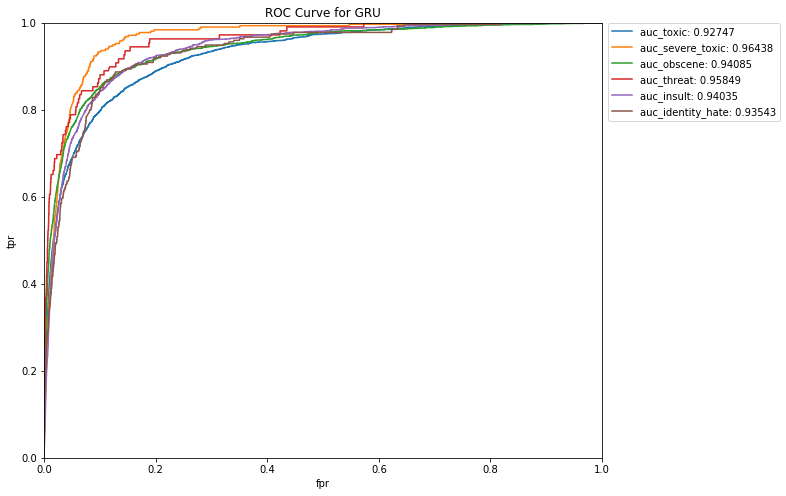

In [90]:
auc_ls = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test.iloc[:, i], gru_test_probs[i])
    auc_value = auc(fpr, tpr)
    auc_ls.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GRU')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

In [91]:
auc_ls

[0.92746560702766212,
 0.96437722752803012,
 0.94085405227228835,
 0.95849493517754136,
 0.94034980145277591,
 0.93542730720606826]